In [157]:
import torch
import numpy as np
import os
import cv2
import kornia
import matplotlib.pyplot as plt
from models.convlstm import warp_frame_depth

In [158]:
def read_img(filepath):
    img = cv2.imread(filepath).astype(np.float32) / 255
    img = cv2.resize(img, (640, 480))
    return torch.tensor(img)

def read_gt_depth(filepath):
    # Read depth image and camera pose
    gt_depth = cv2.imread(filepath, -1).astype(np.float32)
    gt_depth = cv2.resize(gt_depth, (64, 48), interpolation=cv2.INTER_NEAREST)
    gt_depth /= 1000.  # depth is saved in 16-bit PNG in millimeters
    return torch.tensor(gt_depth, dtype=torch.float32)

def read_cam_file(filepath, vid):
    intrinsics = np.loadtxt(os.path.join(filepath, 'intrinsic', 'intrinsic_depth.txt'), delimiter=' ')[:3, :3]
    intrinsics = intrinsics.astype(np.float32)
    poses = np.loadtxt(os.path.join(filepath, 'pose', '{}.txt'.format(str(vid))))
    return torch.tensor(intrinsics, dtype=torch.float32), torch.tensor(poses, dtype=torch.float32)

In [159]:
# img_1 = read_img("F:/D/ScanNetv1/scans/scene0000_00/color/73.jpg")
# img_2 = read_img("F:/D/ScanNetv1/scans/scene0000_00/color/80.jpg")
depth_1 = read_gt_depth("F:/D/ScanNetv1/scans/scene0000_00/depth/73.png")
depth_2 = read_gt_depth("F:/D/ScanNetv1/scans/scene0000_00/depth/80.png")
depth_1_b = depth_1[None, None, :]
depth_2_b = depth_2[None, None, :]
in_1, ext_1 = read_cam_file("F:/D/ScanNetv1/scans/scene0000_00/", 73)
in_2, ext_2 = read_cam_file("F:/D/ScanNetv1/scans/scene0000_00/", 80)
in_1_b, in_2_b, ext_1_b, ext_2_b = in_1[None, :], in_2[None, :], ext_1[None, :], ext_2[None, :]
# trans_2_to_1 = torch.mm(ext_1, torch.inverse(ext_2)).unsqueeze(0)
trans_2_to_1 = torch.bmm(torch.inverse(ext_1_b), ext_2_b).unsqueeze(0)
# trans_1_to_2 = torch.mm(ext_2, torch.inverse(ext_1)).unsqueeze(0)
trans_01 = torch.eye(4).view(1, 4, 4)

In [160]:
diff = torch.sum(torch.abs(depth_1 - depth_2))
# diff = torch.sum(torch.abs(depth_1 - depth_2))
print(diff)

tensor(555.8320)


In [161]:
points_3d_dst_2: torch.Tensor = kornia.depth_to_3d(depth_2_b, in_2_b, False)
points_3d_dst_2 = points_3d_dst_2.permute(0, 2, 3, 1)

points_3d_dst_1: torch.Tensor = kornia.depth_to_3d(depth_1_b, in_1_b, False)
points_3d_dst_1 = points_3d_dst_1.permute(0, 2, 3, 1)  # BxHxWx3
print(torch.sum(torch.abs(points_3d_dst_2 - points_3d_dst_1)))
print(torch.sum(torch.abs(points_3d_dst_2[:, :, :, 2] - points_3d_dst_1[:, :, :, 2])))
print(torch.sum(torch.abs(points_3d_dst_2[:, :, :, 2] - points_3d_dst_2[:, :, :, 2])))

tensor(1048.2485)
tensor(555.8320)
tensor(0.)


In [162]:
points_3d_src = kornia.transform_points(trans_2_to_1, points_3d_dst_2)
points_3d_src[:, :, :, 2] = torch.relu(points_3d_src[:, :, :, 2])
print(torch.sum(torch.abs(points_3d_src - points_3d_dst_1)))
print(torch.sum(torch.abs(points_3d_src[:, :, :, 2] - points_3d_dst_1[:, :, :, 2])))
print(torch.sum(torch.abs(points_3d_src[:, :, :, 2] - points_3d_dst_2[:, :, :, 2])))

tensor(1336.3927)
tensor(719.7537)
tensor(219.0017)


In [ ]:
# project back to pixels
camera_matrix_tmp: torch.Tensor = in_1_b[:, None, None]  # Bx1x1xHxW
points_2d_src: torch.Tensor = kornia.project_points(points_3d_src, camera_matrix_tmp)  # BxHxWx2

# normalize points between [-1 / 1]
height, width = depth_dst.shape[-2:]
points_2d_src_norm: torch.Tensor = kornia.normalize_pixel_coordinates(points_2d_src, height, width)  # BxHxWx2

res = torch.nn.functional.grid_sample(image_src, points_2d_src_norm, align_corners=False, mode=sampling_mode)

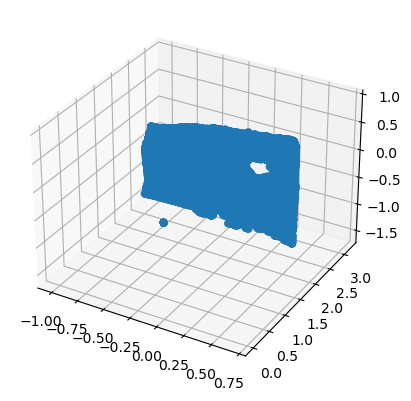

In [99]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
t = points_3d_dst.squeeze(0).numpy()
ax.scatter(t[:, :, 1], t[:, :, 2], t[:, :, 0])

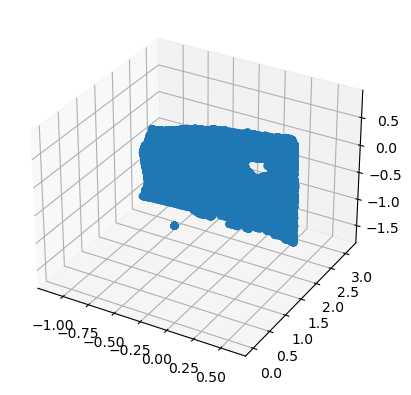

In [100]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
t = points_3d_src.squeeze(0).numpy()
ax.scatter(t[:, :, 1], t[:, :, 2], t[:, :, 0])

In [ ]:
# transform points from source to destination
points_3d_dst = points_3d_dst.permute(0, 2, 3, 1)  # BxHxWx3

# apply transformation to the 3d points
points_3d_src = kornia.transform_points(transformation[:, None], points_3d_dst)  # BxHxWx3
points_3d_src[:, :, :, 2] = torch.relu(points_3d_src[:, :, :, 2])

# project back to pixels
camera_matrix_tmp: torch.Tensor = in_1_b[:, None, None]  # Bx1x1xHxW
points_2d_src: torch.Tensor = kornia.project_points(points_3d_src, camera_matrix_tmp)  # BxHxWx2

In [87]:
print(points_2d_src.shape)

torch.Size([1, 480, 640, 2])


In [33]:
depth_1_b = depth_1[None, None, ...]
depth_2_b = depth_2[None, None, ...]

In [36]:
wrap_depth = warp_frame_depth(depth_1_b, depth_1_b, transformation, torch.tensor(in_1).unsqueeze(0), normalize_points=False, sampling_mode='bilinear')

In [41]:
diff = torch.norm(wrap_depth - depth_2_b)
print(diff)

tensor(482.9741)


In [44]:
print(depth_1[:10, :10])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [52]:
print(wrap_depth.reshape(480, 640)[:10, :10])

tensor([[2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382,
         2.0382],
        [2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382,
         2.0382],
        [2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382,
         2.0382],
        [2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382,
         2.0382],
        [2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382,
         2.0382],
        [2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382,
         2.0382],
        [2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382,
         2.0382],
        [2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382,
         2.0382],
        [2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382,
         2.0382],
        [2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382, 2.0382,
         2.0382]])


In [45]:
print(depth_2[:10, :10])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [88]:
image = torch.tensor([[[[2.0, 2.0],
                        [6.0, 6.0]]]], dtype=torch.float32)

grid = torch.tensor([[[[-1.0, -1.0],[0.0, -1.0],[1.0, -1.0],
                       [-1.0, 0.0],[0.0, 0.0],[1.0, 0.0],
                       [-1.0, 1.0],[0.0, 1.0],[1.0, 1.0]]]], dtype=torch.float32)
sampled_image = torch.nn.functional.grid_sample(image, grid)

print("Original Image:")
print(image)
print("Sampled Image:")
print(sampled_image.reshape(3, 3))

Original Image:
tensor([[[[2., 2.],
          [6., 6.]]]])
Sampled Image:
tensor([[0.5000, 1.0000, 0.5000],
        [2.0000, 4.0000, 2.0000],
        [1.5000, 3.0000, 6.0000]])


D:\Softwares\miniconda3\envs\cu117\lib\site-packages\torch\nn\functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
